# Managing Clustered Networks

This tutorial will cover the common issue of a network that is "clustered", meaning that some pores are not connected the main body of the network. This is fairly common when extracting networks from tomogram, but can occur when getting creative with networks like stitching two together. A clustered network causes problems for the numerical solvers because it leads to "singular" matrices (i.e. they cannot be solved). Below we will explain what this means, and how to fix it.

In [40]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt

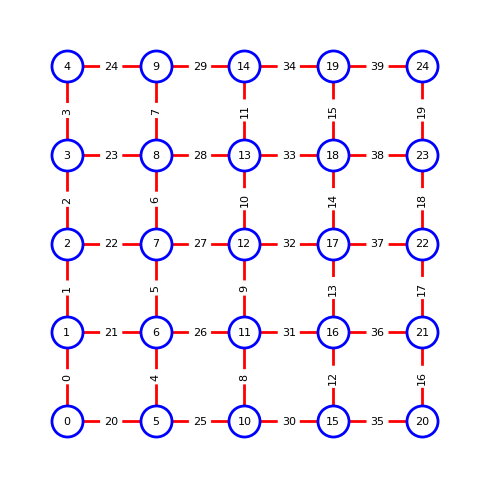

In [41]:
pn = op.network.Demo(shape=[5, 5 ,1])
ax = op.visualization.plot_tutorial(pn, font_size=8)

## Creating a Clustered Network

Now that we've created a network, lets `trim` some throats to create clusters of isolated pores:

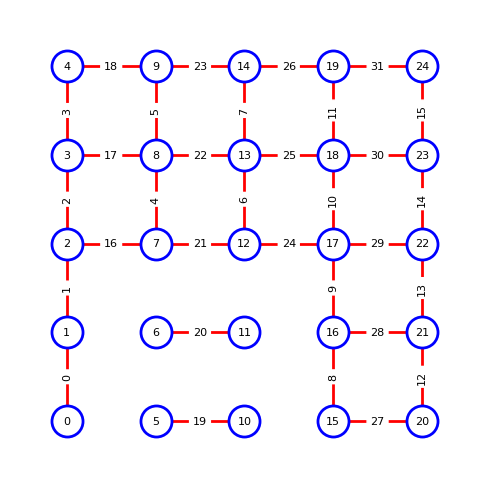

In [42]:
op.topotools.trim(network=pn, throats=[4, 5, 8, 9, 20, 21, 30, 31])
ax = op.visualization.plot_tutorial(pn, font_size=8)

Now we can have 3 total "clusters", two small clusters at the bottom plus one large cluster which constitutes the rest of the network. 

## Illustrating the Problem
Let's first see the problem this creates and why. This requires running (or attempting to run) a transport simulation.

In [43]:
w = op.phase.Water(network=pn)
w.add_model(propname='throat.hydraulic_conductance',
            model=op.models.physics.hydraulic_conductance.generic_hydraulic)

In [44]:
flow = op.algorithms.StokesFlow(network=pn, phase=w)
flow.set_value_BC(pores=pn.pores('left'), values=200_000)
flow.set_value_BC(pores=pn.pores('right'), values=100_000)
try:
    flow.run()
except Exception as e:
    print(e)

Your network is clustered, making Ax = b ill-conditioned


As we can see above, attempting to run `flow` resulted in an Exception with a message about the matrix being singular. Let's see how a clustered network creates this problem. Let's print the A matrix as an image:

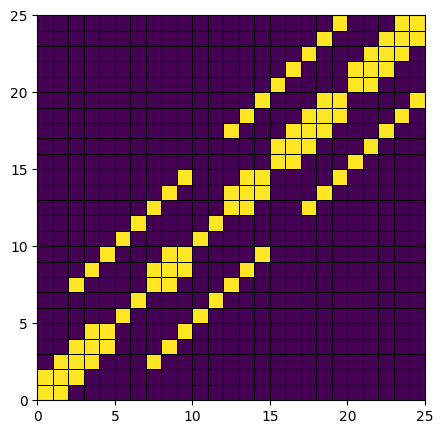

In [45]:
fix, ax = plt.subplots(figsize=[5, 5])
A = np.array(flow.A.todense() != 0)
ax.pcolormesh(A, edgecolors='k', linewidth=0.5);

Referring to the network visualization above we can see that pores 5 and 10 are connected to each other, but not to any other pores. Looking at the A matrix above we can this reflected in the pattern. We can see that on row 5 there is an entry in the diagonal (5, 5) and a second entry at column 10 (5, 10). Now looking at row 10 we see an entry on the diagonal (10, 10) and a entry at column 5 (10, 5). These off-diagonal entries represent the conductance values between pores 5 and 10 (and between 10 and 5). The key point to note is that NO OTHER entries are present on either row. This means that the mass balance equations for pores 5 and 10 are not coupled to the rest of the equations. Another way to say is that pores 5 and 10 form their own independent matrix which can be solved in isolation since they don't exchange mass with any of the other pores...however, we can't solve this 'mini-system' because we have not specified any boundary conditions for it.  

## Fixing Clustered Networks

This is easy to see by eye, but we need to tell OpenPNM to find them so we can begin to fix the problem. In version 3 we added many new pore-scale models to the ``models.network`` libary, among them are `cluster_number` and `cluster_size`.  Let's add these two models to the network and see what we get:

In [46]:
pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Demo at 0x1b2c0709ef0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                       25 / 25
  3  throat.conns                                                      32 / 32
  4  pore.coordination_number                                          25 / 25
  5  pore.max_size                                                     25 / 25
  6  throat.spacing                                                    32 / 32
  7  pore.seed                                                         25 / 25
  8  pore.diameter                                                     25 / 25
  9  throat.max_size                                                   32 / 32
 10  

We can see that cluster number and size have been added to the list of properties.  Let's inspect them:

In [47]:
pn['pore.cluster_number']

array([0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

We can see that most pores a labeled 0, meaning they belong to cluster 0. However, there are a few with cluster numbers of 1 and  2, which we know correspond to the two small clusters in our network.  We *could* solve our current problem by trimming these pores, but let's do it the proper way. Had we not looked at the network visualization, We would not actually know that cluster 0 is the *main* cluster.  We can look at the *size* of each cluster instead:

In [48]:
pn['pore.cluster_size']

array([21., 21., 21., 21., 21.,  2.,  2., 21., 21., 21.,  2.,  2., 21.,
       21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.])

Now we can see that most pores belong to a large cluster of size 21, where there are a few on small clusters. Now we can clearly tell which pores should be trimmed:

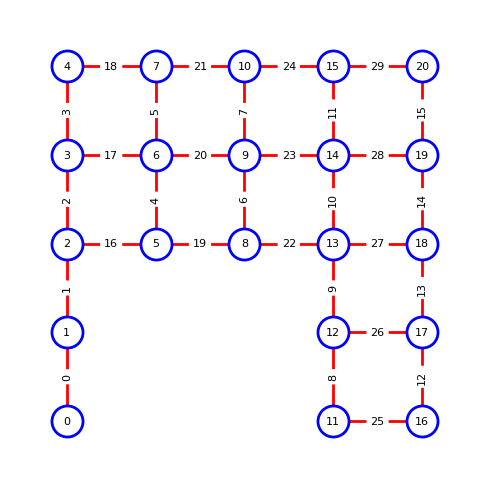

In [49]:
Ps = pn['pore.cluster_size'] < 21
op.topotools.trim(network=pn, pores=Ps)
ax = op.visualization.plot_tutorial(pn, font_size=8)

Now we can see only a single cluster.  Without even re-running the pore-scale models we can see that the pores with a cluster number other than 0 have been removed:

In [50]:
pn['pore.cluster_number']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

Now we can run the `flow` algorithm without a problem, though note that we need to create a new algorithm since the previous one was created based on the number of pores and throats in the clustered network.

In [53]:
flow = op.algorithms.StokesFlow(network=pn, phase=w)
flow.set_value_BC(pores=pn.pores('left'), values=200_000)
flow.set_value_BC(pores=pn.pores('right'), values=100_000)
flow.run()
print(flow.x)

[200000.         200000.         200000.         200000.
 200000.         174104.35922877 171699.02786866 175326.59446026
 148814.66711071 164144.88530979 169904.06100996 101634.55634677
 103828.91192167 109554.37137998 125747.64122525 134332.28799001
 100000.         100000.         100000.         100000.
 100000.        ]


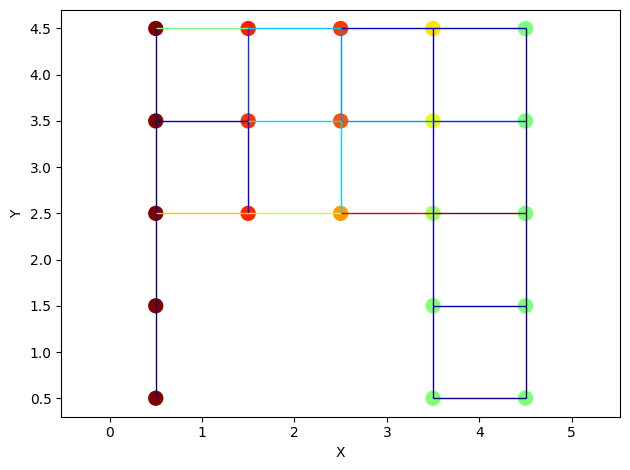

In [58]:
ax = op.visualization.plot_connections(network=pn, color_by=flow.rate(throats=pn.Ts, mode='single'))
op.visualization.plot_coordinates(network=pn, color_by=flow.x, ax=ax, markersize=100)